In [39]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

from sklearn import manifold, decomposition, cluster, preprocessing
from sklearn.model_selection import train_test_split

import itertools

from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_comp.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

full_history = full_history.drop('index', axis=1)

In [3]:
artists = pd.read_json('data/artist_info.json')

In [19]:
def get_unique():
    unique_history = full_history.drop('timestamp', axis=1)
    return unique_history.drop_duplicates('id')

len(full_history)/len(get_unique())

1.9713631156930127

In [12]:
collective_artists = [artists for artists in full_history.loc[full_history['artists'].notnull(), 'artists']]
    
collective_artists = np.array(list(itertools.chain(*collective_artists)))
unique_artists, artist_counts = np.unique(collective_artists, return_counts=True)

artist_df = pd.DataFrame({'id': unique_artists, 'listens': artist_counts})
artists = pd.merge(artists, artist_df, on='id')

In [14]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [15]:
full_history['duration'] = full_history['duration_ms'] / 1000 / 60
full_history['log_loudness'] = np.log(-1*full_history['loudness']+1)
full_history['tempo'] = full_history['tempo'].apply(round)
full_history['tempo'] = full_history['tempo'].apply(lambda x: x if x < 168 else x/2)
full_history['timestamp_64'] = pd.DatetimeIndex(full_history['timestamp']).view('int64') // pd.Timedelta(1, unit='s')
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)
full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)
full_history = full_history.drop(['duration_ms', 'liveness', 'loudness', 'release'], axis=1)

In [16]:
latest_day = full_history['timestamp'].max()
day_range = (latest_day - full_history['timestamp'].min()).days

In [17]:
history_timing = full_history[['id', 'artists', 'timestamp_64']]

In [28]:
song_info = []

u = get_unique()
unique_ids = u['id']
unique_names = u['name']

for song in tqdm(unique_ids):
    listens = history_timing[history_timing['id'] == song]
    
    quality = []
    
    for artist in listens['artists']:
        quality.append(artists.loc[artists['id'] == artist[0], 'listens'].values[0])
        
    spread = (listens['timestamp_64'].max() - listens['timestamp_64'].min()) / (60 * 60 * 24)
    
    distance = (latest_day.timestamp() - listens['timestamp_64'].max()) / (60 * 60 * 24)
    
    song_info.append([spread, distance, len(listens), max(quality)])
    
song_info = np.array(song_info)

A Jupyter Widget

In [42]:
song_info_scaled = preprocessing.minmax_scale(song_info)

[ 0.55283035  0.24829477]


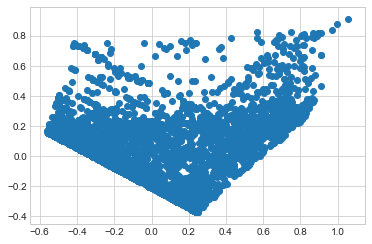

In [43]:
pca = decomposition.PCA(2)

pca_fit = pca.fit_transform(song_info_scaled[:, :].astype(float))

print(pca.explained_variance_ratio_)

# sns.stripplot(pca_fit[:, 0], jitter=True)

plt.scatter(pca_fit[:, 0], pca_fit[:, 1]);

In [44]:
locs = np.argwhere(pca_fit[:, 1] > 0.8)
# locs = pca_fit[:, 0].argsort()[::-1][:10]

In [45]:
unique_names.values[locs], unique_ids.values[locs]

(array([['WASTE'],
        ['FACE'],
        ['TEAM'],
        ["'Till I Collapse"],
        ['SUMMER'],
        ['STUPID'],
        ['Big Weenie'],
        ['ZIPPER'],
        ['BLEACH'],
        ['Rabbit Run - Soundtrack Version'],
        ['Superman'],
        ['When The Music Stops'],
        ['BOOGIE']], dtype=object), array([['1cuYCAodLWgzhwE2KFZ8rC'],
        ['5bknBRjKJZ643DAN2w8Yoy'],
        ['3dzi1yJbrxUaPS3yjn9SgV'],
        ['4xkOaSrkexMciUUogZKVTS'],
        ['66dQdXAbtuPdSasezCQVZE'],
        ['01oc1NWevpGhtCkiX5flPH'],
        ['4dh34dyav8M5jCN3yidn8Z'],
        ['1m4C9zlV89rXTfXStluvec'],
        ['0dWOFwdXrbBUYqD9DLsoyK'],
        ['30KKYkJ0lonfKI2eaLACnZ'],
        ['4woTEX1wYOTGDqNXuavlRC'],
        ['73qINA7ccO03wxD8nsJalr'],
        ['3NuN59jpH3B5cNa2M4r7XG']], dtype=object))